# Pneumonia Detection using Mask-RCNN and COCO

# Goal: 
#### Detect the Pneumonia in this format (confidence, x-min, y-min, width, height)

# Data

In [1]:
#Dataset: RSNA Pneumonia Detection Challenge with transfer learning (https://www.kaggle.com/competitions/rsna-pneumonia-detection-challenge/data)

#Reference: 
#https://www.kaggle.com/code/rahulssr/mask-rcnn-and-coco-transfer-learning-lb-0-155
#https://www.kaggle.com/code/ashishtiwari98/object-detection-maskrcnn-rsna-pneumonia

#### File descriptions:
- stage_2_train.csv - the training set. Contains patientIds and bounding box / target information.
- stage_2_sample_submission.csv - a sample submission file in the correct format. Contains patientIds for the test set. Note that the sample submission contains one box per image, but there is no limit to the number of bounding boxes that can be assigned to a given image.
- stage_2_detailed_class_info.csv - provides detailed information about the type of positive or negative class for each image.

#### Data fields
- patientId _- A patientId. Each patientId corresponds to a unique image.
- x - the upper-left x coordinate of the bounding box.
- y - the upper-left y coordinate of the bounding box.
- width - the width of the bounding box.
- height - the height of the bounding box.
- Target - the binary Target, indicating whether this sample has evidence of pneumonia.

# Data Annotation: 
### VIA (VGG Image Annotator, https://www.robots.ox.ac.uk/~vgg/software/via/), University of Oxford

### Sample Annotation:
[](http://)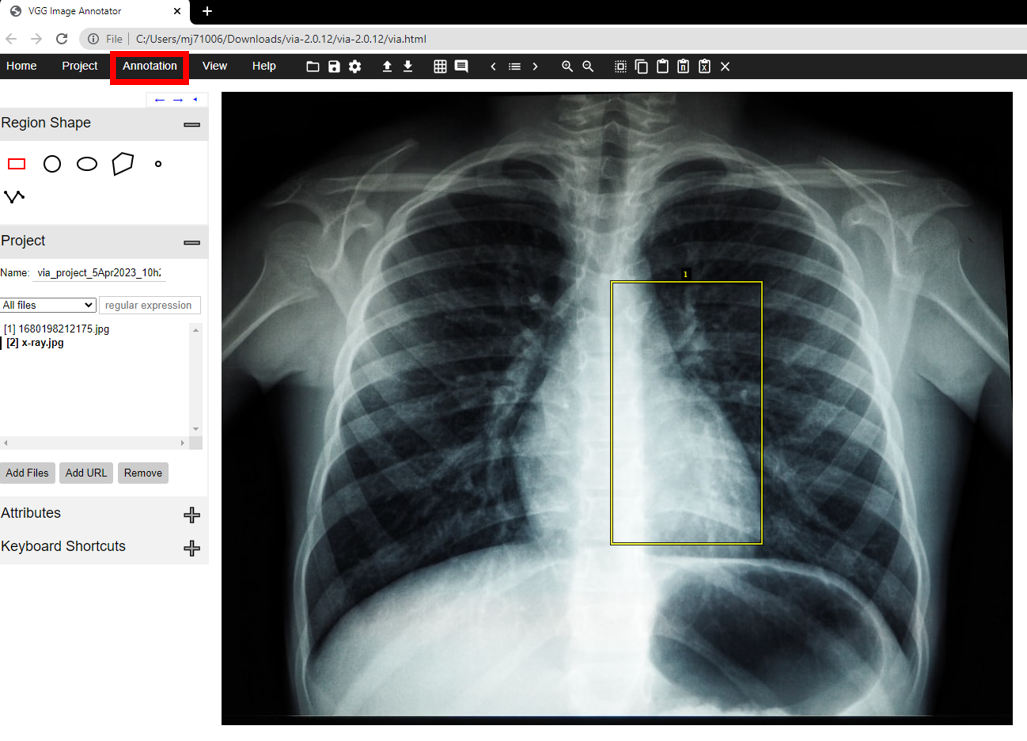
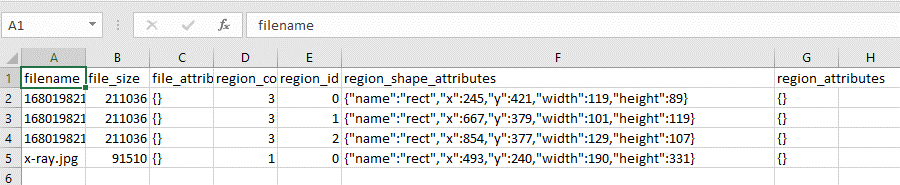

# 1. Load python packages 

In [2]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
from sklearn.model_selection import KFold

In [3]:
DATA_DIR = '/kaggle/input'

# Directory to save logs and trained model
ROOT_DIR = '/kaggle/working'

### 1.1 Install and import Matterport's Mask-RCNN model from github

In [4]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
#!python setup.py -q install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 137.67 MiB | 23.94 MiB/s, done.
Resolving deltas: 100% (558/558), done.


In [5]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [6]:
train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')

### 1.2 Download COCO pre-trained weights

In [7]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw-r--r-- 1 root root 246M Dec  6  2021 mask_rcnn_coco.h5


# 2. Some preprocessing functions and classes for Mask-RCNN

In [8]:
# dicom_fps: is a list of the dicom image path and filenames 
# image_annotions: is a dictionary of the annotations keyed by the filenames
# parsing the dataset: returns a list of the image filenames and the annotations dictionary

def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [9]:

# Class for overridding the training deep learning configuration 
class DetectorConfig(Config):
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.68  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.01

    STEPS_PER_EPOCH = 200

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [10]:
# Dataset class for training pneumonia detection
class DetectorDataset(utils.Dataset):

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

# 3. Examine the annotation data, parse the dataset, and view dicom fields

In [17]:
# training dataset
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [34]:
print("Train CSV: ", anns['Target'].size)
print("Pneumonia: ", anns['Target'].value_counts()[1]*100/anns['Target'].size,"%")
print("No Pneumonia: ", anns['Target'].value_counts()[0]*100/anns['Target'].size,"%")

Train CSV:  30227
Pneumonia:  31.610811526119033 %
No Pneumonia:  68.38918847388096 %


In [56]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [58]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [59]:
# show dicom fields 
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.17008.1517874400.800489
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '38b557eb-bf26-4da1-b6ec-5674cddc9ef2'
(0010, 0020) Patient ID                          LO: '38b557eb-bf26-4da1-b6ec-5674cddc9ef2'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [60]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

# 4. Split the data into training and validation datasets

In [63]:
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)
val_size = 1500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print("Train size: ",len(image_fps_train), ", Validation size: ",len(image_fps_val))
# print(image_fps_val[:6])

Train size:  25184 , Validation size:  1500


### 4.1 Create and prepare the training dataset using the DetectorDataset class.

In [64]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

### 4.2 Check sample train annotation

In [65]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    f938d936-8c4a-497e-9b73-244a22786490
 x                                             NaN
 y                                             NaN
 width                                         NaN
 height                                        NaN
 Target                                          0
 Name: 28109, dtype: object]

### 4.3 Display a random image with bounding boxes

(1024, 1024, 3)
/kaggle/input/stage_2_train_images/165e4595-deeb-4910-b06b-89e2fba035f6.dcm
[1 1]


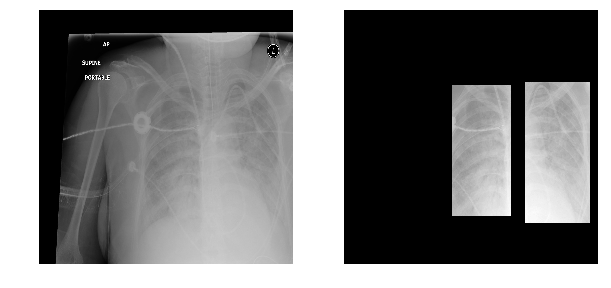

In [66]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

# 5. Image Augmentation

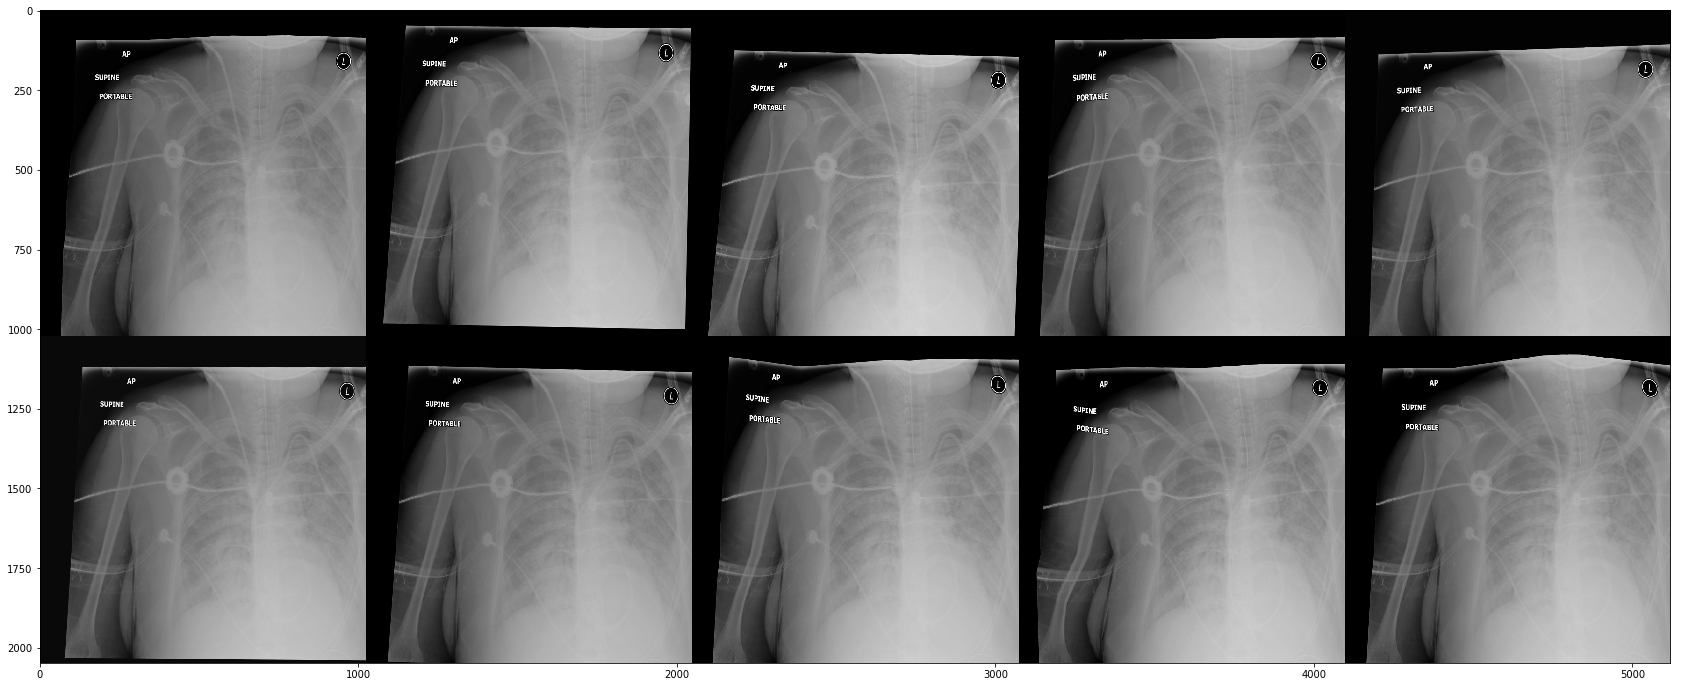

In [67]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

# 6. Train the model
- dataset_train and dataset_val are derived from DetectorDataset 
- DetectorDataset loads images from image filenames and  masks from the annotation data
- model is Mask-RCNN

In [75]:
# Load M-RCNN
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# Load COCO weights
# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

In [74]:
LEARNING_RATE = 0.003

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")

In [23]:
%%time
## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=2,
            layers='heads',
            augmentation=None)  ## no need to augment yet

#history = model.keras_model.history.history


Starting at epoch 0. LR=0.012

Checkpoint Path: /kaggle/working/pneumonia20230405T0442/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4 

In [81]:
history = model.keras_model.history.history

In [76]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=6,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 0. LR=0.003

Checkpoint Path: /kaggle/working/pneumonia20230405T1534/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b  

NameError: name 'history' is not defined

In [85]:
new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

In [77]:
# %%time
# model.train(dataset_train, dataset_val,
#             learning_rate=LEARNING_RATE,
#             epochs=6,
#             layers='all',
#             augmentation=augmentation)

# new_history = model.keras_model.history.history
# for k in new_history: history[k] = history[k] + new_history[k]

In [78]:
# %%time
# model.train(dataset_train, dataset_val,
#             learning_rate=LEARNING_RATE/5,
#             epochs=16,
#             layers='all',
#             augmentation=augmentation)

# new_history = model.keras_model.history.history
# for k in new_history: history[k] = history[k] + new_history[k]

# 7. Plot Evaluation

In [86]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,1.489964,0.014990,0.413649,0.228477,0.461666,0.371174,1.680491,0.018937,0.480270,0.228651,0.521355,0.431271
2,1.453126,0.014313,0.445633,0.169046,0.440751,0.383376,1.442084,0.012495,0.407108,0.192203,0.431761,0.398511
3,1.438451,0.013103,0.484608,0.134905,0.419796,0.386032,1.452303,0.012502,0.431865,0.195842,0.420833,0.391253
4,1.467827,0.013537,0.463798,0.206547,0.411537,0.372401,1.425031,0.011947,0.443129,0.172534,0.408061,0.389353
5,1.459511,0.010335,0.453859,0.206370,0.414721,0.374219,1.402019,0.011540,0.416069,0.195122,0.391989,0.387293
6,1.363526,0.011575,0.436848,0.151408,0.390923,0.372765,1.364052,0.011403,0.404909,0.168404,0.390659,0.388670
7,1.489964,0.014990,0.413649,0.228477,0.461666,0.371174,1.680491,0.018937,0.480270,0.228651,0.521355,0.431271
8,1.453126,0.014313,0.445633,0.169046,0.440751,0.383376,1.442084,0.012495,0.407108,0.192203,0.431761,0.398511
9,1.438451,0.013103,0.484608,0.134905,0.419796,0.386032,1.452303,0.012502,0.431865,0.195842,0.420833,0.391253
10,1.467827,0.013537,0.463798,0.206547,0.411537,0.372401,1.425031,0.011947,0.443129,0.172534,0.408061,0.389353


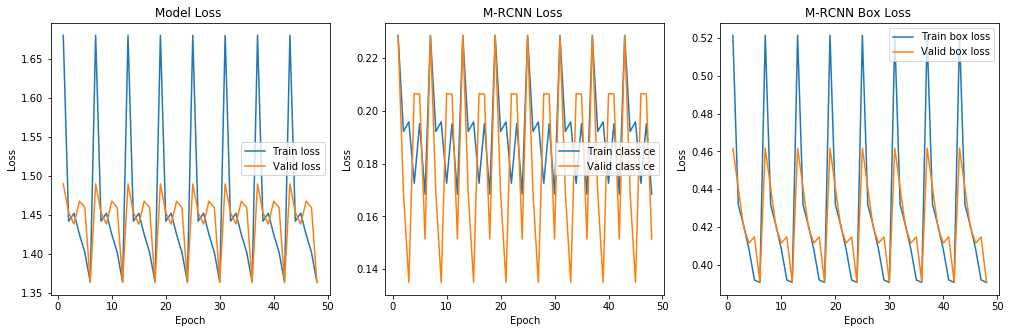

In [104]:
# Plot the loss and accuracy
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.title ("Model Loss ")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title ("M-RCNN Loss ")
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title ("M-RCNN Box Loss ")

plt.show()

In [91]:
# Find best epoch size
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

Best Epoch: 6 1.3635256206989288


# 8. Validate the model

### 8.1 preload the model file

In [92]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /kaggle/working/pneumonia20230405T1534/mask_rcnn_pneumonia_0006.h5


### 8.2 Deployment of the model for validation set

In [93]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /kaggle/working/pneumonia20230405T1534/mask_rcnn_pneumonia_0006.h5
Re-starting from epoch 6


In [94]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

### 8.3 Apply validation dataset to check. 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 



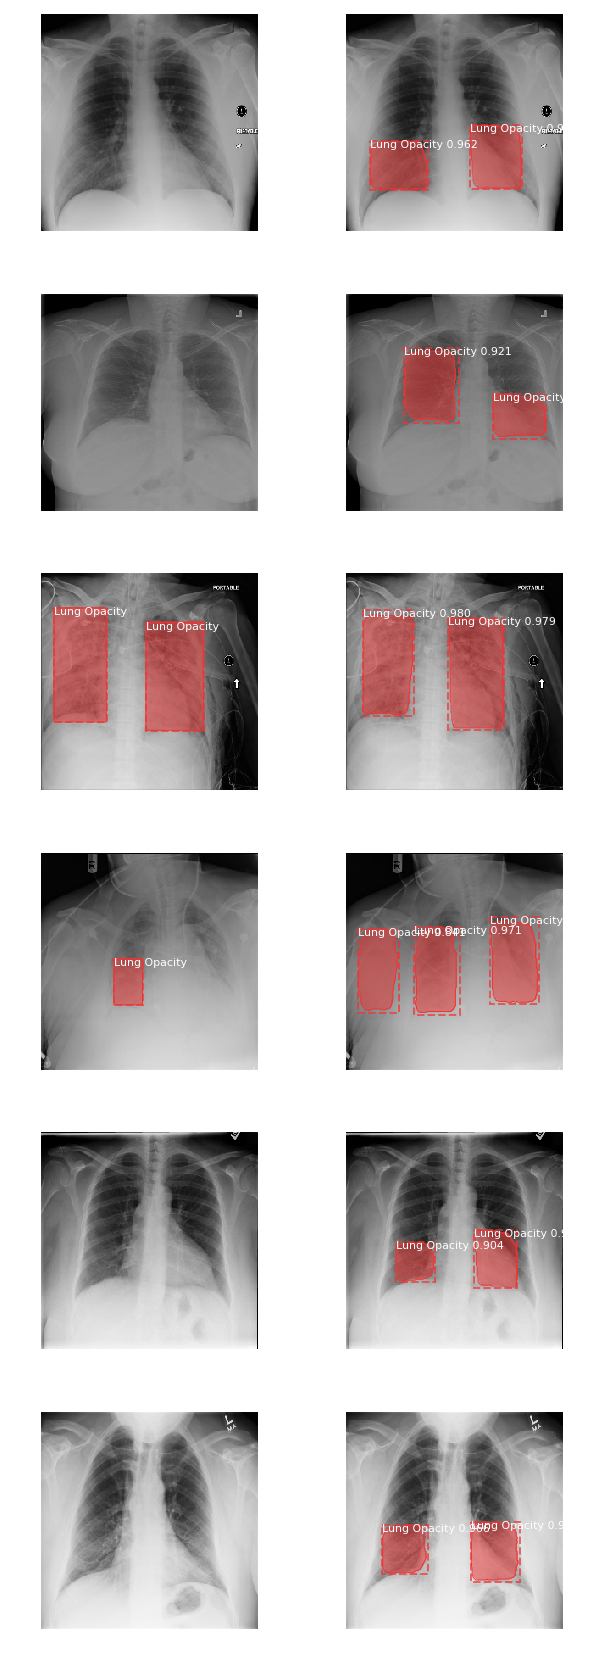

In [95]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

# 9. Test the model

In [96]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

### 9.1 Final steps - Create the submission file to save prediction on test set

In [97]:
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=0.95):
    
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")

### 9.2 Prediction on the test set

In [98]:
# Predict the model on test set 
submission_fp = os.path.join(ROOT_DIR, 'submission.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

100%|██████████| 3000/3000 [08:02<00:00,  6.33it/s]

/kaggle/working/submission.csv


In [100]:
# Print the submission file for testing set 
output = pd.read_csv(submission_fp)
output.head(60)

,patientId,PredictionString
0,261e52e1-5c56-4d95-84a2-26841f98ed70,0.97 204.0 228.0 252.0 472.0 0.95 640.0 264.0...
1,11112783-2e0b-488c-bfb6-f8c7c782baa3,0.95 256.0 512.0 160.0 152.0
2,2cf31164-d6db-43c0-beb4-90dd15363216,0.96 236.0 460.0 228.0 188.0
3,03f9f71c-8f7f-47c1-b39a-14fbd3d30c98,0.96 248.0 468.0 192.0 264.0
4,2de21def-1d19-4204-8189-6c4ce33a5aec,NaN
5,1145a218-f3d2-449f-a436-8ed5d86ec591,0.98 192.0 376.0 248.0 332.0 0.96 600.0 284.0...
6,249b1047-ece4-490d-b903-5e457981986a,0.97 244.0 404.0 200.0 228.0 0.95 584.0 528.0...
7,029760af-1273-42c5-a214-0267fbe016fe,0.96 200.0 172.0 224.0 332.0
8,28dc9ac8-e269-4834-8483-aeddd22cb878,NaN
9,2b20c1cd-d62d-49d5-a5c9-43780436c308,0.97 228.0 560.0 236.0 280.0


2afe02a3-06da-42fa-b68f-3e9c921e5fb9
[135  47 198 106]
x 188 y 540 h 236 w 252
[152 155 193 194]
x 620 y 608 h 156 w 164
2e18279e-0068-4ef2-9c10-8bbb6fc9272e
[ 40  36 181 108]
x 144 y 160 h 288 w 564
[129 139 209 203]
x 556 y 516 h 256 w 320
22dd02e5-5ca4-4493-af90-17178e558450
[ 67  49 188 110]
x 196 y 268 h 244 w 484
[ 62 142 193 207]
x 568 y 248 h 260 w 524
2853a995-743e-43d8-9ea4-068ffc6bf420
[114  53 160 117]
x 212 y 456 h 256 w 184
[106 152 155 199]
x 608 y 424 h 188 w 196
2977d766-7faa-42d5-943d-ec65ef284430
[ 73  40 156 107]
x 160 y 292 h 268 w 332
29e0eb1e-8292-4eb5-a335-75f5174de4d3
[ 66  54 132 101]
x 216 y 264 h 188 w 264
[ 76 143 149 200]
x 572 y 304 h 228 w 292
242bcc3b-ab55-4f12-a414-00384ba48e9c
[113  57 152 107]
x 228 y 452 h 200 w 156


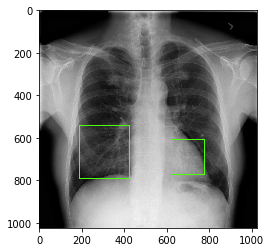

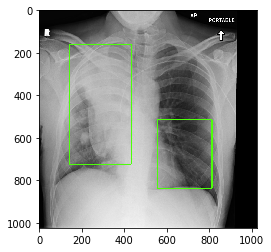

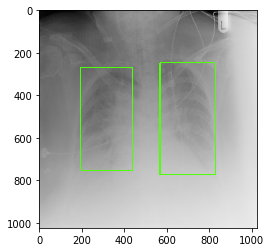

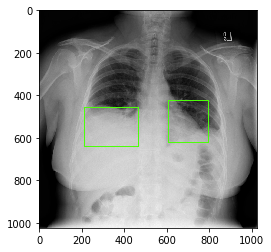

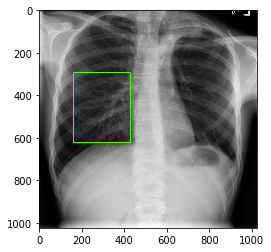

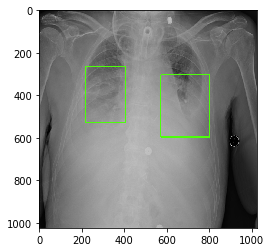

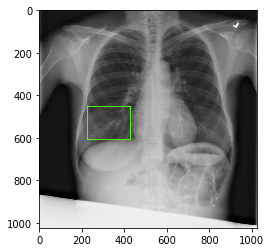

In [102]:
# show a few test image detection example
def visualize(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    
    # original image 
    image = ds.pixel_array
    
    # assume square image 
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)

visualize()
visualize()
visualize()
visualize()
visualize()
visualize()
visualize()